# Synthesis data for anomaly detection

In [1]:
from pathlib import Path
from tqdm import tqdm

import torch
import numpy as np
from PIL import Image
from IPython.display import display

from models import Generator

In [2]:
device = 'cuda' # 'cpu'
LATENT_SIZE = 512
LABEL_SIZE  = 2 # #classes
EMBEDDING_SIZE = 1
RESOLUTION  = 128
CKPT_PATH = '/home/dgx/yct/StyleGAN2_Pytorch/results/00006-1gpu-itri-noaug-finetune/checkpoints/ckpt-297500.pt'
BATCH_SIZE = 40
OUT_DIR = Path('~/yct/samples_1015/').expanduser()
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [3]:
ckpt = torch.load(CKPT_PATH)['g_ema']

In [4]:
g_ema = Generator(LATENT_SIZE, LABEL_SIZE, RESOLUTION, embedding_size=EMBEDDING_SIZE, is_training=False).to(device)
g_ema.eval()
g_ema.load_state_dict(ckpt)

<All keys matched successfully>

### generate dataset

In [5]:
from tqdm import tqdm
SUB_CLASS = ['NG', 'OK']
for sub in SUB_CLASS:
    (OUT_DIR / sub).mkdir()

idx = 0
for i in range(LABEL_SIZE):
    print(SUB_CLASS[i])
    for b in tqdm(range(10)):
        noise = [torch.randn(BATCH_SIZE, LATENT_SIZE).to(device)]
        fake_label = torch.full((BATCH_SIZE,), i, dtype=torch.long).to(device)

        samples = g_ema(noise, labels_in=fake_label)[0].cpu().detach().numpy()
        samples = np.clip(samples * 127.5 + 127.5, 0, 255).astype(np.uint8)
        samples = np.moveaxis(samples, 1, -1)

        for j, img in enumerate(samples):
            Image.fromarray(img).save(OUT_DIR / SUB_CLASS[i] / f'{SUB_CLASS[i]}-{str(idx).zfill(6)}.png')
            idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

NG


  0%|          | 0/10 [00:00<?, ?it/s]

OK


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


## Display Grid images

In [7]:
def gallery(array, ncols=1):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

NG


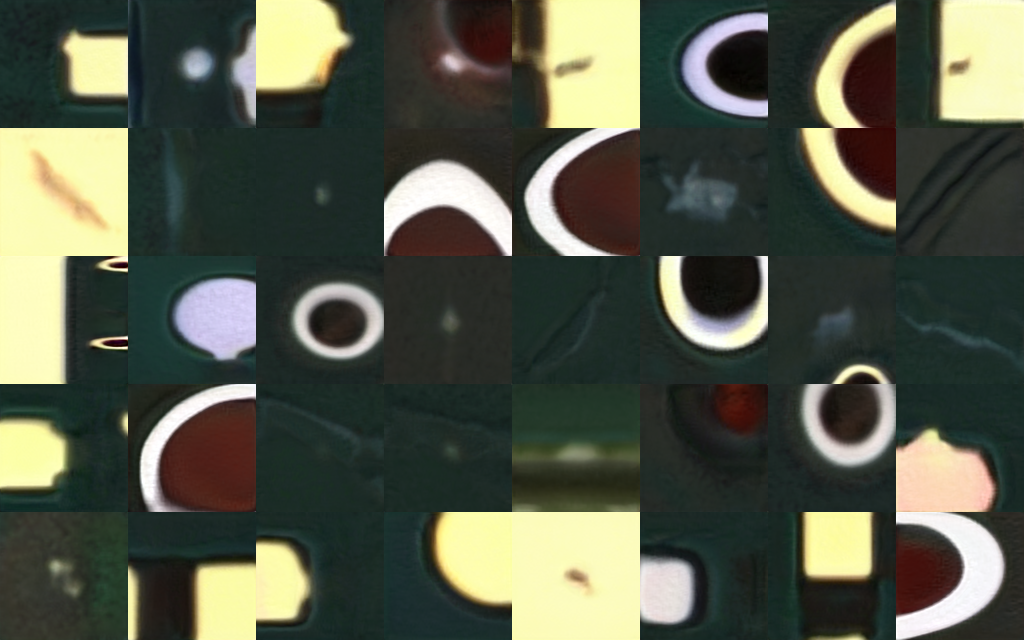

OK


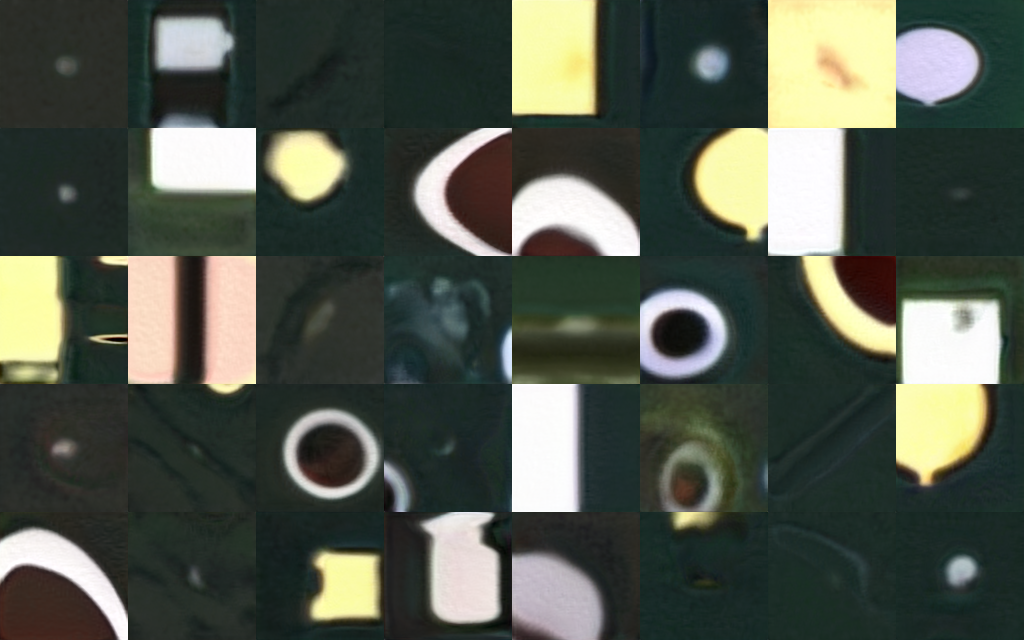

In [8]:
import random
import skimage.io as io

# grid image
data_root = OUT_DIR
for clas in ['NG', 'OK']:
    print(clas)
    samples = []
    img_paths = random.sample(list((data_root / clas).glob('*.png')), 40)
    for p in img_paths:
        samples.append(io.imread(p))
        
    grid_img = Image.fromarray(gallery(np.array(samples), ncols=8))
    # grid_img.save(OUT_DIR / SUB_CLASS[i] / 'grid.png')
    display(grid_img)